<a href="https://colab.research.google.com/github/Rajsoni03/NLP-Insincere-Questions-Classifier/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>NLP-Insincere-Questions-Classifier</h1>

## Importing Libraries

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

import os

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


     |████████████████████████████████| 1.0MB 12.2MB/s 


## Download and Import the Quora Insincere Questions Dataset

Dataset Link - https://www.kaggle.com/c/quora-insincere-questions-classification/data

In [2]:
# mount drive to notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# clone data from kaggle
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/AI Colab/Kaggle'
!kaggle competitions download --force -c quora-insincere-questions-classification -f train.csv

100% 54.9M/54.9M [00:00<00:00, 57.0MB/s]



In [4]:
# read train.csv file
df = pd.read_csv('/content/train.csv.zip', compression='zip', low_memory=False)
df.shape

(1306122, 3)

In [5]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


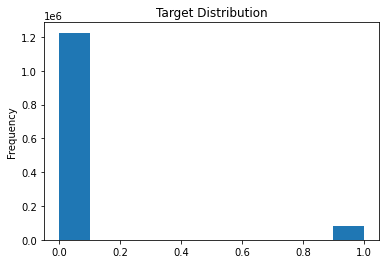

In [6]:
df['target'].plot(kind='hist', title='Target Distribution')

There are class imbalance problem with dataset

## Data Preprocessing

In [7]:
# handle class imbalance problem
rus  = RandomUnderSampler(random_state=42)
df_final, _ = rus.fit_sample(df, df['target'])
df_final = pd.DataFrame(df_final, columns=['qid', 'question_text','target'])
df_final.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(161620, 3)

In [8]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161620 entries, 0 to 161619
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   qid            161620 non-null  object
 1   question_text  161620 non-null  object
 2   target         161620 non-null  object
dtypes: object(3)
memory usage: 3.7+ MB


In [9]:
# convert target type from obj to int
df_final = df_final.astype({'target': 'int32'})
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161620 entries, 0 to 161619
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   qid            161620 non-null  object
 1   question_text  161620 non-null  object
 2   target         161620 non-null  int32 
dtypes: int32(1), object(2)
memory usage: 3.1+ MB


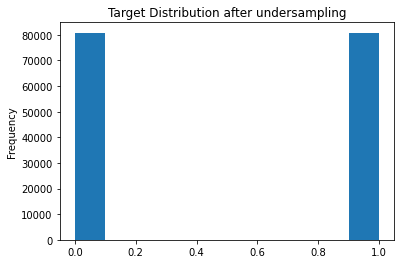

In [10]:
df_final['target'].plot(kind='hist', title='Target Distribution after undersampling');

In [11]:
# split data into training and validation set in ratio of 9:1
X_train, X_val, Y_train, Y_val = train_test_split(df_final['question_text'], df_final['target'], random_state=42, train_size=0.9, stratify=df_final.target.values)

print('No. of samples Training data :', X_train.shape[0])
print('No. of samples Validation data :', X_val.shape[0]) 

No. of samples Training data : 145458
No. of samples Validation data : 16162


## Define Function to Train and Evaluate Models

In [12]:
logdir = '/content/tensorboard_logs'
os.mkdir(logdir)

In [13]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
  hub_layer = hub.KerasLayer(module_url, input_shape=[], output_shape=[embed_size], dtype=tf.string, trainable=trainable)

  model = tf.keras.models.Sequential([
                                      hub_layer,
                                      tf.keras.layers.Dense(256, activation='relu'),
                                      tf.keras.layers.Dense(64, activation='relu'),
                                      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.summary()
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss = 'binary_crossentropy',
                metrics=['accuracy']
                )
  
  history = model.fit(X_train, Y_train,
                      validation_data = (X_val, Y_val),
                      epochs = 20,
                      batch_size = 32,
                      verbose = 1,
                      callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min'),
                                   tf.keras.callbacks.TensorBoard(log_dir=f'{logdir}/{name}')]
                      )
  return history

## Train Various Text Classification Models

In [14]:
histories = {}

Model - 1 <br>
[gnews-swivel-20dim](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1)

In [15]:
histories['gnews-swivel-20dim'] = train_and_evaluate_model("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1",
                                                                     embed_size=20,
                                                                     name='gnews-swivel-20dim',
                                                                     trainable=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 256)               5376      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 421,909
Trainable params: 21,889
Non-trainable params: 400,020
_________________________________________________________________
Epoch 1/20
4546/4546 [==============================] - 24s 5ms/step - loss: 0.4328 - accuracy: 0.8019 - val_loss: 0.4076 - val_accuracy: 0.8178
Epoch 2/20
4546/4546 [==============================] - 21s 5ms/step - loss: 0.4082 - accuracy: 0.

Model - 2 <br>
[nnlm-en-dim50]("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1")

In [16]:
histories['nnlm-en-dim50'] = train_and_evaluate_model("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", 
                                                      embed_size=50, 
                                                      name='nnlm-en-dim50', 
                                                      trainable=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               13056     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 48,220,169
Trainable params: 29,569
Non-trainable params: 48,190,600
_________________________________________________________________
Epoch 1/20
4546/4546 [==============================] - 22s 5ms/step - loss: 0.4411 - accuracy: 0.7949 - val_loss: 0.4062 - val_accuracy: 0.8191
Epoch 2/20
4546/4546 [==============================] - 22s 5ms/step - loss: 0.3990 - accu

Model - 3 <br>
[nnlm-en-dim128]("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1")

In [17]:
histories['nnlm-en-dim128'] = train_and_evaluate_model("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1",
                                                       embed_size=128,
                                                       name='nnlm-en-dim128',
                                                       trainable=False)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 124,692,225
Trainable params: 49,537
Non-trainable params: 124,642,688
_________________________________________________________________
Epoch 1/20
4546/4546 [==============================] - 22s 5ms/step - loss: 0.3874 - accuracy: 0.8284 - val_loss: 0.3514 - val_accuracy: 0.8508
Epoch 2/20
4546/4546 [==============================] - 22s 5ms/step - loss: 0.3349 - ac

Model - 4 <br>
[universal-sentence-encoder]("https://tfhub.dev/google/universal-sentence-encoder/4")

In [18]:
histories['universal-sentence-encoder'] = train_and_evaluate_model("https://tfhub.dev/google/universal-sentence-encoder/4",
                                                                   embed_size=512,
                                                                   name='universal-sentence-encoder',
                                                                   trainable=False)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 256,945,665
Trainable params: 147,841
Non-trainable params: 256,797,824
_________________________________________________________________
Epoch 1/20
4546/4546 [==============================] - 63s 13ms/step - loss: 0.2841 - accuracy: 0.8897 - val_loss: 0.2542 - val_accuracy: 0.9009
Epoch 2/20
4546/4546 [==============================] - 60s 13ms/step - loss: 0.2299 -

Model - 5 <br>
[universal-sentence-encoder-large]("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [19]:
histories['universal-sentence-encoder-large'] = train_and_evaluate_model("https://tfhub.dev/google/universal-sentence-encoder-large/5",
                                                                         embed_size=512,
                                                                         name='universal-sentence-encoder-large',
                                                                         trainable=False)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 512)               147354880 
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 147,502,721
Trainable params: 147,841
Non-trainable params: 147,354,880
_________________________________________________________________
Epoch 1/20
4546/4546 [==============================] - 230s 46ms/step - loss: 0.2479 - accuracy: 0.9033 - val_loss: 0.2151 - val_accuracy: 0.9217
Epoch 2/20
4546/4546 [==============================] - 203s 45ms/step - loss: 0.1983

## Evaluate Models

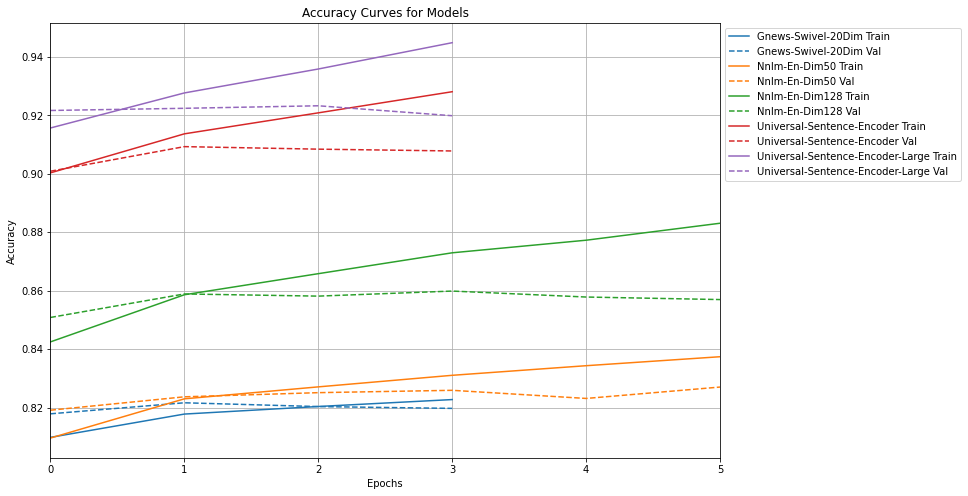

In [20]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

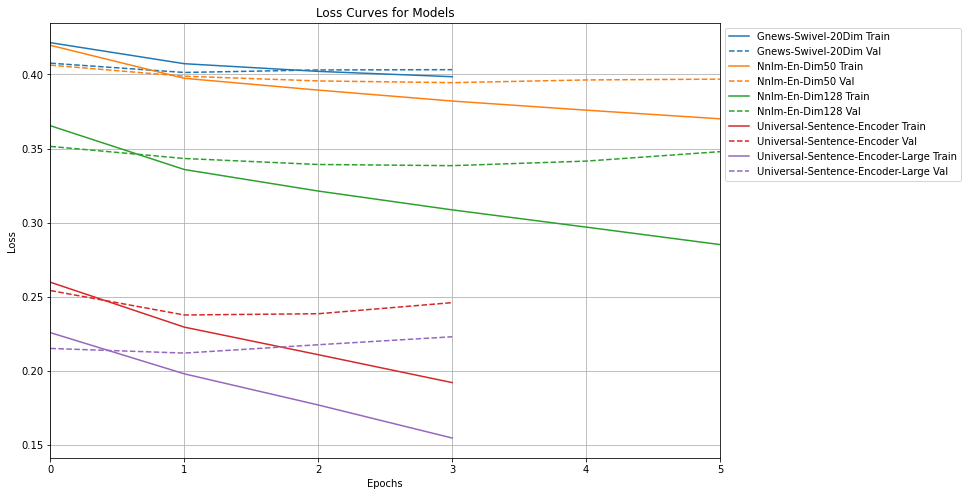

In [21]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()